# Metro Bike Share -- k-means Clustering

### This script contains the following:

#### 1. Importing libraries and data
#### 2. Data cleaning and manipulation
#### 3. The elbow technique
#### 4. K-means clustering
#### 5. Conclusion

## 01.Importing libraries and data 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import sklearn
from sklearn.cluster import KMeans 
import pylab as pl

In [2]:
%matplotlib inline

In [3]:
# Define path
path= r'C:\Users\ashan\OneDrive\桌面\Data Analytic\Metro Bike Share'

In [4]:
# Import data set
df = pd.read_csv(os.path.join(path,'02 Data','Prepared Data', 'Cleaned_2023.csv'),index_col = 0) 

In [5]:
df.head()

,trip_id,duration,fare_without_discount,start_time,month,day_of_month,time_of_start,day_of_week,end_time,start_station,...,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,bike_type,fare,subscription
0,231787362,9,1.75,1/1/2023 0:41,1,1,0,1,1/1/2023 0:50,4204,...,4210,33.984341,-118.471550,23373,30,One Way,Monthly Pass,electric,0.00,17
1,231801471,97,7.00,1/1/2023 1:05,1,1,1,1,1/1/2023 2:42,3054,...,3054,34.039219,-118.236488,13870,1,Round Trip,Walk-up,standard,7.00,0
2,231794062,15,1.75,1/1/2023 1:11,1,1,1,1,1/1/2023 1:26,3037,...,3068,34.053200,-118.250954,23942,1,One Way,Walk-up,electric,2.75,0
3,231794664,26,1.75,1/1/2023 1:31,1,1,1,1,1/1/2023 1:57,3063,...,4454,34.017899,-118.291718,22873,1,One Way,Walk-up,electric,2.75,0
4,231794562,8,1.75,1/1/2023 1:44,1,1,1,1,1/1/2023 1:52,3066,...,3026,34.063179,-118.245880,14790,1,One Way,Walk-up,standard,1.75,0


In [6]:
df.shape

(433658, 22)

## 02.Data cleaning and manipulation

In [7]:
# Check for missing values
df.isnull().sum() # No missing values!

trip_id                  0
duration                 0
fare_without_discount    0
start_time               0
month                    0
day_of_month             0
time_of_start            0
day_of_week              0
end_time                 0
start_station            0
start_lat                0
start_lon                0
end_station              0
end_lat                  0
end_lon                  0
bike_id                  0
plan_duration            0
trip_route_category      0
passholder_type          0
bike_type                0
fare                     0
subscription             0
dtype: int64

In [8]:
# Find duplicates
df_dups = df[df.duplicated()]
df_dups.shape # No duplicates!

(0, 22)

In [9]:
# Check mixed data type
for col in df.columns.tolist():
      weird = (df[[col]].applymap(type) != df[[col]].iloc[0].apply(type)).any(axis = 1)
      if len (df[weird]) > 0:
        print (col)

C:\Users\ashan\AppData\Local\Temp\ipykernel_16280\1902000819.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  weird = (df[[col]].applymap(type) != df[[col]].iloc[0].apply(type)).any(axis = 1)
C:\Users\ashan\AppData\Local\Temp\ipykernel_16280\1902000819.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  weird = (df[[col]].applymap(type) != df[[col]].iloc[0].apply(type)).any(axis = 1)
C:\Users\ashan\AppData\Local\Temp\ipykernel_16280\1902000819.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  weird = (df[[col]].applymap(type) != df[[col]].iloc[0].apply(type)).any(axis = 1)
C:\Users\ashan\AppData\Local\Temp\ipykernel_16280\1902000819.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  weird = (df[[col]].applymap(type) != df[[col]].iloc[0].apply(type)).any(axis = 1)
C:\Users\ashan\AppData\Local\Temp\ipykernel_16280\1902000819.py:3: F

No mixed data type

In [10]:
# Subset numerical columns for clustering

df_clus = df[['duration','fare_without_discount','subscription']]
df_clus

,duration,fare_without_discount,subscription
0,9,1.75,17
1,97,7.00,0
2,15,1.75,0
3,26,1.75,0
4,8,1.75,0
...,...,...,...
126689,4,1.75,150
126690,4,1.75,0
126691,35,3.50,0
126692,33,3.50,17


In [11]:
# Rename column

df_clus.rename(columns = {'fare_without_discount' : 'fare_n'}, inplace = True)

C:\Users\ashan\AppData\Local\Temp\ipykernel_16280\1477936065.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clus.rename(columns = {'fare_without_discount' : 'fare_n'}, inplace = True)


In [12]:
df_clus['subscription'].value_counts()

subscription
17     264545
0       90102
150     40004
5       39007
Name: count, dtype: int64

###### Note: The number of subscription is the subscription fee, and it also represents the type of bike ride passholder. 17 is monthly passholders, 0 is walk-up riders,  150 is annual passholders, and 5 is daily passholder.

## 03. The elbow technique

In [13]:
# Defines the range of potential clusters in the data.

num_cl = range(1, 10) 
kmeans = [KMeans(n_clusters=i) for i in num_cl] 

In [14]:
# Creates a score to represents the rate of variation 

score = [kmeans[i].fit(df_clus).score(df_clus) for i in range(len(kmeans))] 

score

C:\Users\ashan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ashan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ashan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ashan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

[-3423641982.5641336,
 -1579618950.8264012,
 -880327551.217139,
 -470511383.7509585,
 -291520166.5133326,
 -196071140.61236215,
 -149412243.21156698,
 -115752565.38381934,
 -94025086.12266709]

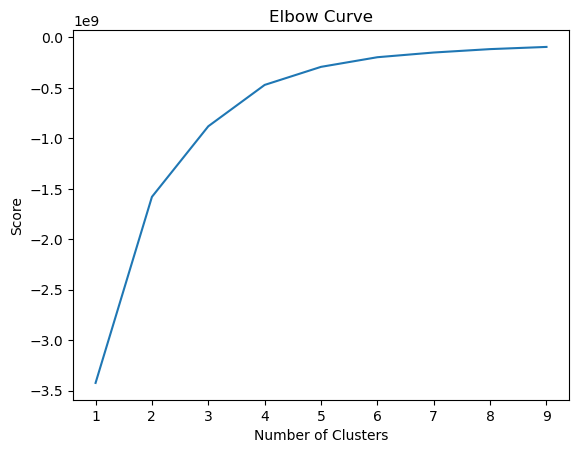

In [15]:
# Visualize the curve
pl.plot(num_cl,score)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

###### According to the visualization, starting from 4, the curve is flatterning. Thus 4 is the optimum number for the clusters.

## 04. K-means clustering

In [16]:
# Create the k-means object
kmeans = KMeans(n_clusters = 4) 

In [17]:
# Fit the k-means object to data
kmeans.fit(df_clus)

C:\Users\ashan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=4)

In [18]:
# Create a column to the dataframe with value corresponding to which cluster every observation belongs

df_clus['clusters'] = kmeans.fit_predict(df_clus)

C:\Users\ashan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ashan\AppData\Local\Temp\ipykernel_16280\1210491478.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clus['clusters'] = kmeans.fit_predict(df_clus)


In [19]:
# Check the column.

df_clus.head()

,duration,fare_n,subscription,clusters
0,9,1.75,17,1
1,97,7.00,0,1
2,15,1.75,0,1
3,26,1.75,0,1
4,8,1.75,0,1


In [20]:
# Check the count of each cluster

df_clus['clusters'].value_counts()

clusters
1    373538
3     39797
2     18630
0      1693
Name: count, dtype: int64

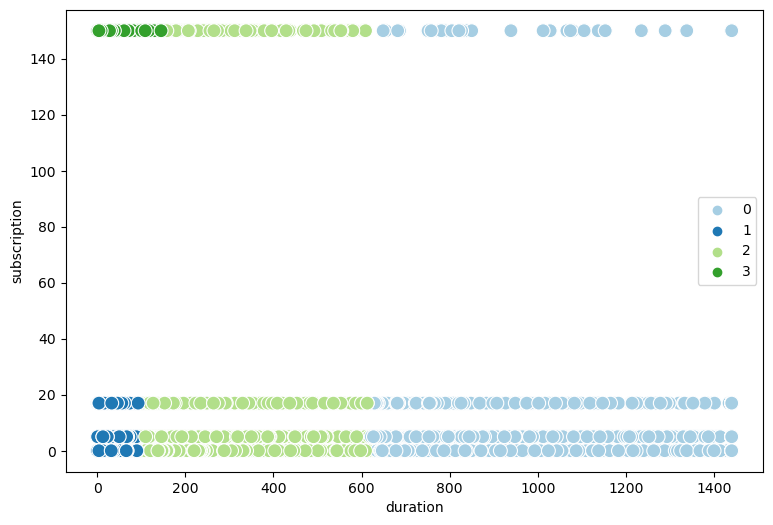

In [21]:
# Visualize the realtion of bike trip duration and subcription
custom_palette = sns.color_palette("Paired", n_colors=len(set(kmeans.labels_)))
plt.figure(figsize=(9,6))
ax = sns.scatterplot(x=df_clus['duration'], y=df_clus['subscription'], hue=kmeans.labels_, s=100, palette=custom_palette)
ax.grid(False) 
plt.xlabel('duration') # Label x-axis.
plt.ylabel('subscription') # Label y-axis.
plt.show()

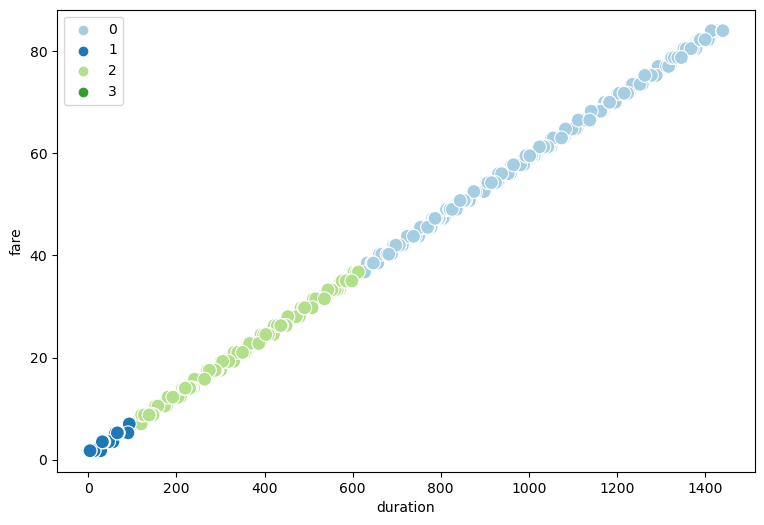

In [22]:
# Plot the clusters for the "fare" and "duration" variables.

custom_palette = sns.color_palette("Paired", n_colors=len(set(kmeans.labels_)))

plt.figure(figsize=(9,6))
ax = sns.scatterplot(x=df_clus['duration'], y=df_clus['fare_n'], hue=kmeans.labels_, s=100, palette=custom_palette)

ax.grid(False) 
plt.xlabel('duration') # Label x-axis.
plt.ylabel('fare') # Label y-axis.
plt.show()

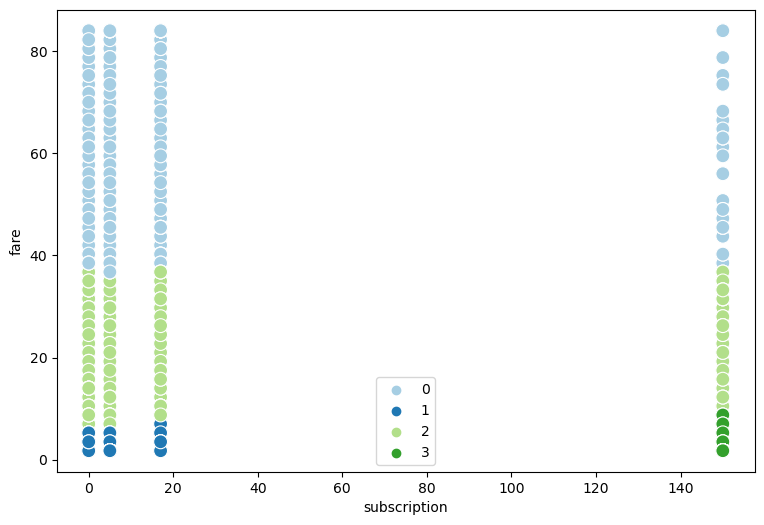

In [23]:
custom_palette = sns.color_palette("Paired", n_colors=len(set(kmeans.labels_)))

plt.figure(figsize=(9,6))
ax = sns.scatterplot(x=df_clus['subscription'], y=df_clus['fare_n'], hue=kmeans.labels_, s=100, palette=custom_palette)

ax.grid(False) 
plt.xlabel('subscription') # Label x-axis.
plt.ylabel('fare') # Label y-axis.
plt.show()

In [24]:
# Categorize each custer

df_clus.loc[df_clus['clusters'] == 3, 'cluster'] = 'dark green'
df_clus.loc[df_clus['clusters'] == 2, 'cluster'] = 'light green'
df_clus.loc[df_clus['clusters'] == 1, 'cluster'] = 'dark blue'
df_clus.loc[df_clus['clusters'] == 0, 'cluster'] = 'light blue'

C:\Users\ashan\AppData\Local\Temp\ipykernel_16280\952661479.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clus.loc[df_clus['clusters'] == 3, 'cluster'] = 'dark green'


In [25]:
# Check each custer statistics

df_clus.groupby('cluster').agg({'duration':['mean', 'median'], 
                         'subscription':['mean', 'median'], 
                         'fare_n':['mean', 'median']})

duration         subscription            fare_n       
                    mean  median         mean median       mean median
cluster                                                               
dark blue      20.782649    15.0    12.303230   17.0   2.199144   1.75
dark green     11.330326     8.0   150.000000  150.0   1.848500   1.75
light blue   1061.734790  1033.0     7.795629    5.0  62.593768  61.25
light green   178.156361   144.0     6.142136    5.0  11.223108   8.75

In [26]:
df_clus['cluster'].value_counts()

cluster
dark blue      373538
dark green      39797
light green     18630
light blue       1693
Name: count, dtype: int64

## 05. Conclusion

###### There are four groups of bike trips in this 2023 dataset. 


* ###### Dark blue cluster: 
this group had the fewest trips but has the longest trip duration during year 2023. Becasue trip duration has liner relationship with fare, this group had the highest amount of mean and median of trip fare without discount. In addition, as this group had a median value of 5 for subscription, the rider of this group most likely were daypass holders or walk-up casual riders. According the scartter plot of duration and subscription, fewer annual pass holders belonged to this group.

* ###### Dark green cluster: 
this group had 2nd fewest bike trips with medium trip duration. With the same median subscription but a little bit less mean value with the dark blue group, this group appeared had more walk-up casual riders than the dark blue group. This group had much less fare amount in the mean and median value compare to the dark blue group.


* ###### Light blue cluster: 
this group had the most bike trip count. With 20 min average trip duration, this group of bike trips were more contributed by monthly passholders, daypass holders and casual riders.


* ###### Light green cluster: 
this group of bike trips were made by annal pass holders. It has the least fare and the shortest duration average.